# Fitting of ΔGs

In [36]:
import ultraplot as uplt
from pyhdx.datasets import read_dynamx
from pyhdx import HDXMeasurement
from pyhdx.fitting import (
    fit_rates_half_time_interpolate,
    fit_rates_weighted_average,
    fit_gibbs_global,
)
from pyhdx.process import filter_peptides, apply_control, correct_d_uptake
from pathlib import Path
from dask.distributed import Client
import numpy as np


We load the sample SecB dataset, apply the control, and create an ``HDXMeasurement`` object.

In [37]:
fpath = Path() / ".." / ".." / "tests" / "test_data" / "input" / "ecSecB_apo.csv"
data = read_dynamx(fpath)

fd = {"state": "Full deuteration control", "exposure": {"value": 0.167, "unit": "min"}}

fd_df = filter_peptides(data, **fd)
peptides = filter_peptides(data, state="SecB WT apo")  # , query=["exposure != 0."])
peptides_control = apply_control(peptides, fd_df)
peptides_corrected = correct_d_uptake(peptides_control)

sequence = "MSEQNNTEMTFQIQRIYTKDISFEAPNAPHVFQKDWQPEVKLDLDTASSQLADDVYEVVLRVTVTASLGEETAFLCEVQQGGIFSIAGIEGTQMAHCLGAYCPNILFPYARECITSMVSRGTFPQLNLAPVNFDALFMNYLQQQAGEGTEEHQDA"
hdxm = HDXMeasurement(peptides_corrected, temperature=303.15, pH=8.0, sequence=sequence)


The first step is to obtain initial guesses for the observed rate of D-exchange.
By determining the timepoint at which 0.5 RFU (relative fractional uptake) is reached, and subsequently converting to rate, a rough estimate of exchange rate per residue can be obtained. Here, RFU values are mapped from peptides to individual residues by weighted averaging (where the weight is the inverse of peptide length).

In [38]:
fr_half_time = fit_rates_half_time_interpolate(hdxm)
fr_half_time.output


,rate
r_number,
10,0.054455
11,0.054455
12,0.035301
13,0.035301
14,0.035301
...,...
151,0.136605
152,0.136460
153,0.136460


A more accurate result can be obtained by fitting the per-residue/timepoint RFU values to a biexponential association curve.
This process is more time-consuming and can optionally be processed in parallel by Dask.

In [39]:
client = Client()
fr_wt_avg = fit_rates_weighted_average(hdxm, client=client)


c:\Users\jhsmi\pp\PyHDX\.venv-py310\lib\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 56669 instead
  warnings.warn(


The return value is a ``KineticsFitResult`` object. This object has a list of models and corresponding intervals to where the protein
sequence to which these models apply, and their corresponding ``symfit`` fit result with parameter values. The effective 
exchange rate (units $s^{-1}$) can be extracted, as well as other fit parameters, from this object:

In [40]:
with np.errstate(over="ignore"):
    output = fr_wt_avg.output
output


,rate,k1,k2,r
r_number,,,,
10,0.064476,0.188466,0.001496,0.567997
11,0.064476,0.188466,0.001496,0.567997
12,0.055101,0.193093,0.001586,0.538317
13,0.055101,0.193093,0.001586,0.538317
14,0.055101,0.193093,0.001586,0.538317
...,...,...,...,...
151,0.828595,0.843758,0.000235,0.987547
152,1.899615,0.030137,1.931812,0.011800
153,1.899615,0.030137,1.931812,0.011800


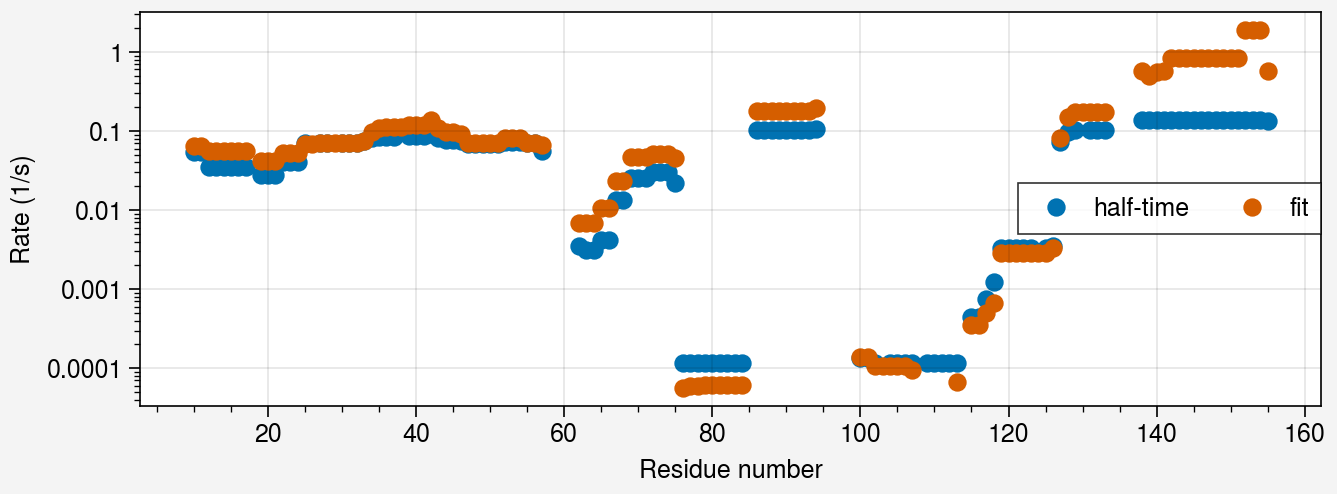

In [41]:
fig, ax = uplt.subplots(aspect=3, axwidth="150mm")
ax.set_yscale("log")
with np.errstate(over="ignore"):
    ax.scatter(fr_half_time.output.index, fr_half_time.output["rate"], label="half-time")
    ax.scatter(fr_wt_avg.output.index, fr_wt_avg.output["rate"], label="fit")

ax.set_xlabel("Residue number")
ax.set_ylabel("Rate (1/s)")
labels = ax.legend()


We can now use the guessed rates to obtain guesses for the Gibbs free energy. Units of Gibbs free energy are J/mol.

In [42]:
with np.errstate(over="ignore"):
    gibbs_guess = hdxm.guess_deltaG(fr_wt_avg.output["rate"])
gibbs_guess


r_number
1               NaN
2               NaN
3               NaN
4               NaN
5               NaN
           ...     
151    11573.755776
152    10036.120416
153    12460.606191
154    12740.075114
155    12740.075114
Length: 155, dtype: float64

To perform the global fit (all peptides and timepoints) use ``fit_gibbs_global``. The number of epochs is set to 1000
here for demonstration but for actually fitting the values should be ~100000.

In [43]:
gibbs_result = fit_gibbs_global(hdxm, gibbs_guess, epochs=1000)
gibbs_output = gibbs_result.output
gibbs_output


100%|██████████| 1000/1000 [00:02<00:00, 479.83it/s]


state    SecB WT apo                                                     \
quantity    sequence           _dG            dG        pfact     k_obs   
r_number                                                                  
10                 T  19781.919285  19781.919285  2561.425910  0.064239   
11                 F  19359.141029  19359.141029  2165.887448  0.063185   
12                 Q  20664.092406  20664.092406  3634.818868  0.054431   
13                 I  16945.224765  16945.224765   831.210736  0.053237   
14                 Q  19008.353382  19008.353382  1884.491402  0.053830   
...              ...           ...           ...          ...       ...   
151                E  11573.540437  11573.540437    98.663025  0.828665   
152                H  10063.692817  10063.692817    54.200504  1.879322   
153                Q  12460.606180  12460.606180   140.280859  1.899615   
154                D  12712.516483  12712.516483   155.025553  1.920365   
155                A  12711.478536  12711.478536   154.961727  0.010085   

state                    
quantity     covariance  
r_number                 
10          1408.327159  
11          1402.756030  
12           785.957980  
13           781.389883  
14           783.474329  
...                 ...  
151         8561.889759  
152       682690.419238  
153       739377.385549  
154       810741.457984  
155         4667.900477  

[146 rows x 6 columns]

Along with ΔG the fit result returns covariances of ΔG and protection factors. The column `k_obs` is the observed rate of
exchange without taking into account the intrinsic exchange rate of each residue. If users want to obtain a result truly
independent of the intrinsic rate of exchange, the regularization value r1 should be set to zero (as this works on ΔG,
which is obtained by taking intrinsic rate of exchange into account) and users should provide their own initial guesses
for ΔG (as determination of initial guesses also uses intrinsic rates of exchange).

In [44]:
gibbs_output["SecB WT apo"]["dG"]

r_number
10     19781.919285
11     19359.141029
12     20664.092406
13     16945.224765
14     19008.353382
           ...     
151    11573.540437
152    10063.692817
153    12460.606180
154    12712.516483
155    12711.478536
Name: dG, Length: 146, dtype: float64

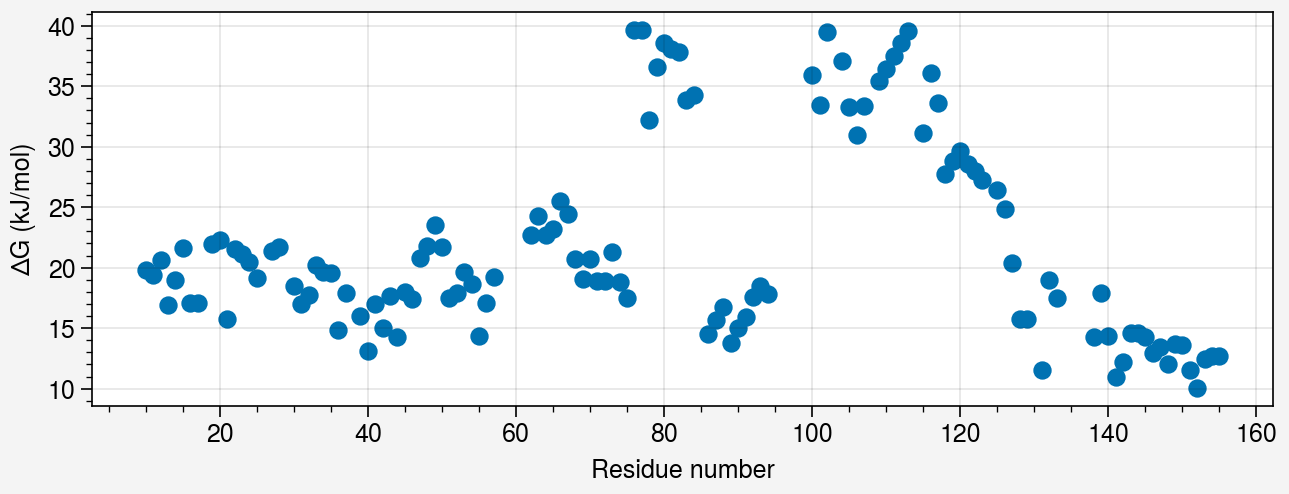

In [45]:
fig, ax = uplt.subplots(aspect=3, axwidth="150mm")
ax.scatter(gibbs_output.index, gibbs_output["SecB WT apo"]["dG"] * 1e-3)
xlabel = ax.set_xlabel("Residue number")
ylabel = ax.set_ylabel("ΔG (kJ/mol)")

#### Number of epochs and overfitting

The returned fit result object also has information on the losses of each epoch of the fittng process. These are
stored as a `pd.DataFrame` in the `losses` attribute. During a successful fitting run, the losses should decrease sharply
and then flatten out.

CartesianAxes(index=(0, 0), number=1)

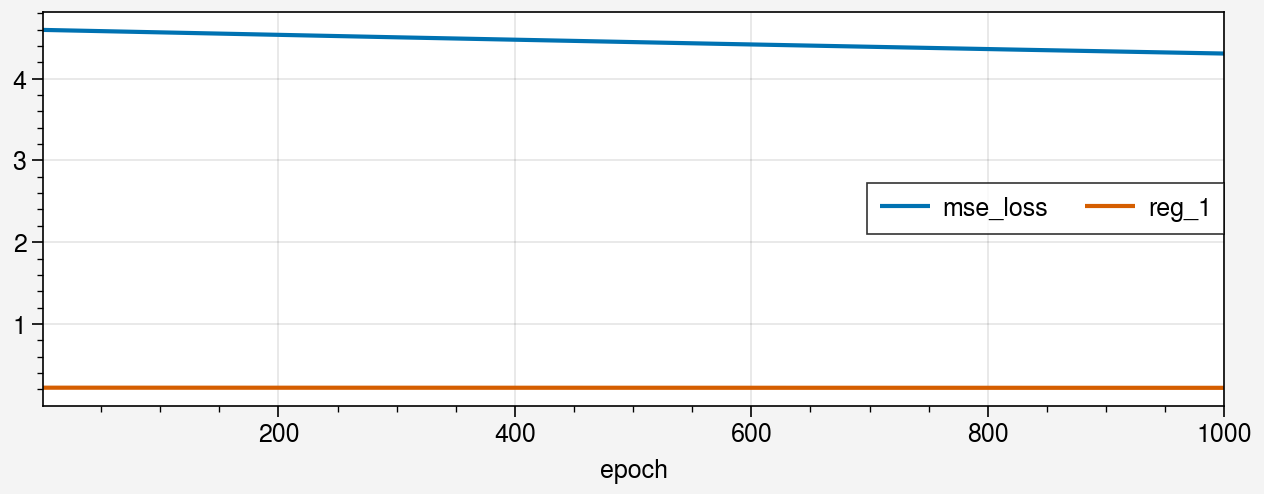

In [46]:
fig, ax = uplt.subplots(aspect=3, axwidth="150mm")
assert gibbs_result.losses is not None
gibbs_result.losses.plot(ax=ax)

In the figure above, `mse_loss` is the loss resulting from differences in calculated D-uptake and measured D-uptake
(mean squared error). The `reg_1` is the loss resulting from the regualizer.

If the losses do not decrease, this is likely due to a too low number of epochs or a too low learning rate.
Lets tune the fit parameters such that we obtain the desired result.

In [47]:
gibbs_result_updated = fit_gibbs_global(hdxm, gibbs_guess, epochs=40000)

100%|██████████| 40000/40000 [01:12<00:00, 549.80it/s]


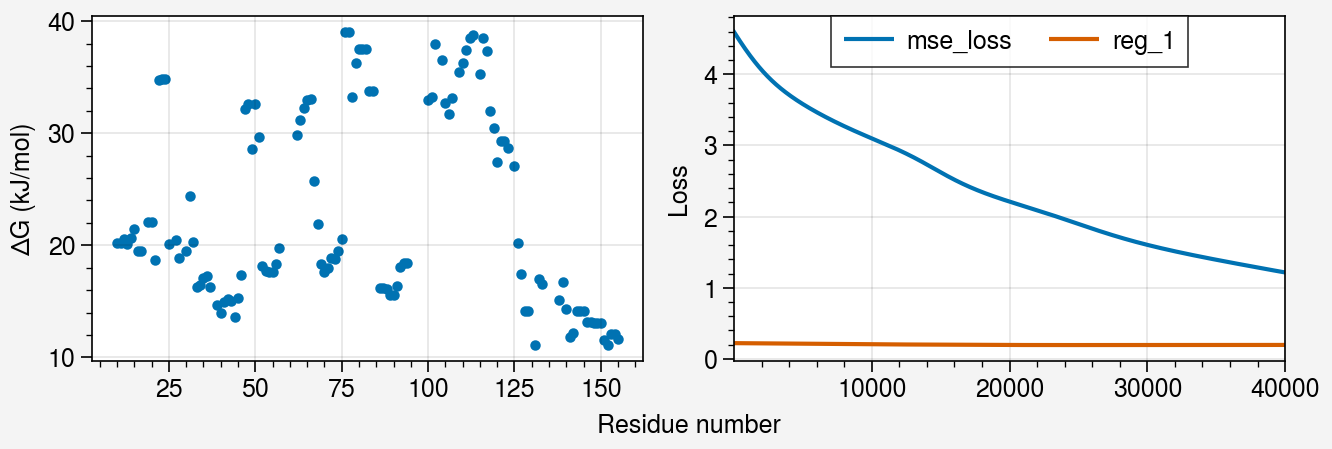

In [48]:
fig, axes = uplt.subplots(ncols=2, refaspect=1.6, axwidth="70mm", sharey=False)
axes[0].scatter(
    gibbs_result_updated.output.index, gibbs_result_updated.output["SecB WT apo"]["dG"] * 1e-3, s=10
)
axes[0].set_xlabel("Residue number")
axes[0].set_ylabel("ΔG (kJ/mol)")
assert gibbs_result_updated.losses is not None
gibbs_result_updated.losses.plot(ax=axes[1])
xlabel = axes[1].set_xlabel("Epochs")
ylabel = axes[1].set_ylabel("Loss")

By increasing the learning rate and the number of epochs, our result improves as the final MSE loss is lower.

With `stop_loss` at 1E-6 and `patience` at 50 (=default), the fitting will not terminate until for 50
epochs the progress (loss decrease) has been less than 1E-6.

The default value of `stop_loss`  is 1E-5. This will ensure optimization will stop when not enough progress is being made
and thereby prevent overfitting. 

Users can keep track of the ΔG values per epoch by using `Checkpoint` callbacks (See templates/04; advanced/experimental usage).


In [49]:
gibbs_result_updated = fit_gibbs_global(
    hdxm, gibbs_guess, epochs=60000, lr=1e5, stop_loss=1e-6, patience=50
)


100%|██████████| 60000/60000 [02:05<00:00, 479.69it/s]


In [50]:
gibbs_result_updated.regularization_percentage


57.3720267605211

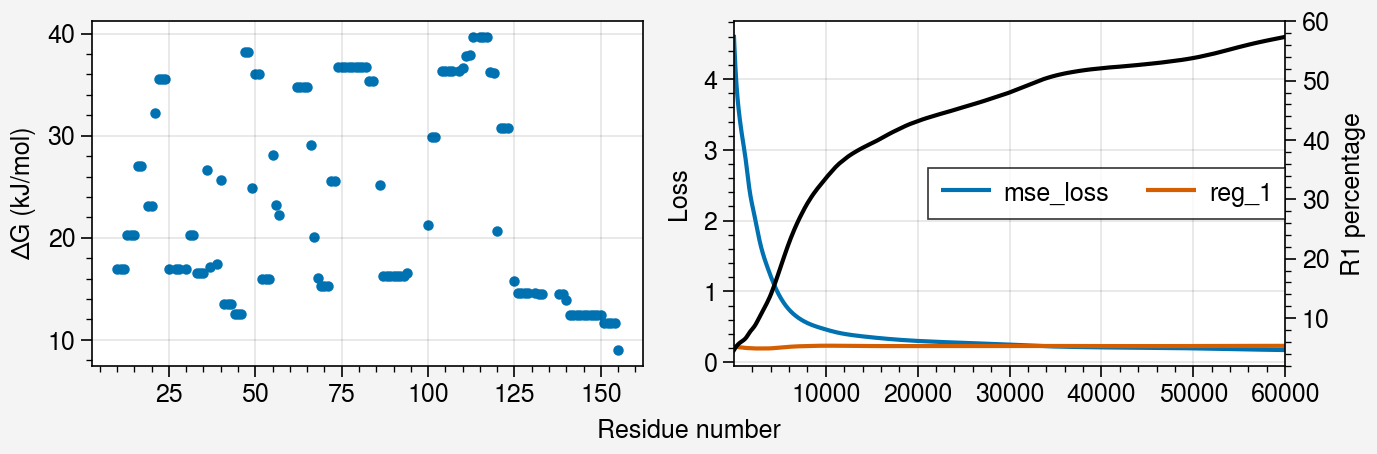

In [51]:
assert gibbs_result_updated.losses is not None

fig, axes = uplt.subplots(ncols=2, refaspect=1.6, axwidth="70mm", sharey=False)
axes[0].scatter(
    gibbs_result_updated.output.index, gibbs_result_updated.output["SecB WT apo"]["dG"] * 1e-3, s=10
)
axes[0].set_xlabel("Residue number")
axes[0].set_ylabel("ΔG (kJ/mol)")

gibbs_result_updated.losses.plot(ax=axes[1])
ax = axes[1].twinx()
ax.set_ylabel("R1 percentage")
percentage = 100 * gibbs_result_updated.losses["reg_1"] / (gibbs_result_updated.losses.sum(axis=1))
ax.plot(percentage, color="k")
xlabel = axes[1].set_xlabel("Epochs")
ylabel = axes[1].set_ylabel("Loss")


In [52]:
assert gibbs_result_updated.losses is not None
gibbs_result_updated.losses.sum(axis=1)

epoch
1        4.816828
2        4.814508
3        4.811804
4        4.808909
5        4.805920
           ...   
59996    0.404717
59997    0.404716
59998    0.404715
59999    0.404712
60000    0.404710
Length: 60000, dtype: float64

With these settings, the losses and the result become highly influenced by the regularizer `r1`, which dampens the result
and removes scatter in ΔG values.

#### The choice of regularizer value r1

The regularizer `r1` acts between subsequent residues minimizing differences between residues, unless data support
these differences. Higher values flatten out the ΔG values along residues, while lower values allow for more
variability.

The main function of `r1` is to mitigate the non-identifiability problem, where if multiple effective exchange rates (ΔG)
values are found within a peptide, it is impossible to know which rate should be assigned to which residue. Among the
possible choices, the regularizer `r1` will bias the result towards the choice of rate per residue assignment with the
least variability along residues.

The 'best' value of r1 depends on the size of the protein and the coverage, (the number/size of peptides). Below is an
example of the differences with regularizer values 0.1, 2 and 5.
In this dataset, despite the fact that for `r1=2` contribution `reg_1` is 50% of `total_loss`, most features in ΔG are
still resolved. In this case, it is recommended to try different values of `r1` (starting low and increasing) and find
the optimal value based on the ΔG result and fit metrics (Total mse loss at fit termination, $\chi^2$ per peptide
and fit curves per peptide (available in web interface)).

In [53]:
r1_vals = [0.1, 2, 5]
results_dict = {}
for r1 in r1_vals:
    print(r1)
    result = fit_gibbs_global(
        hdxm, gibbs_guess, epochs=60000, lr=1e5, stop_loss=1e-5, patience=50, r1=r1
    )
    results_dict[r1] = result


0.1


 32%|███▏      | 19351/60000 [00:46<01:37, 416.55it/s]


2


 36%|███▋      | 21766/60000 [00:49<01:26, 443.91it/s]


5


100%|██████████| 60000/60000 [02:23<00:00, 417.86it/s]


10.012058718942702
55.582488360762895
62.07377214309632


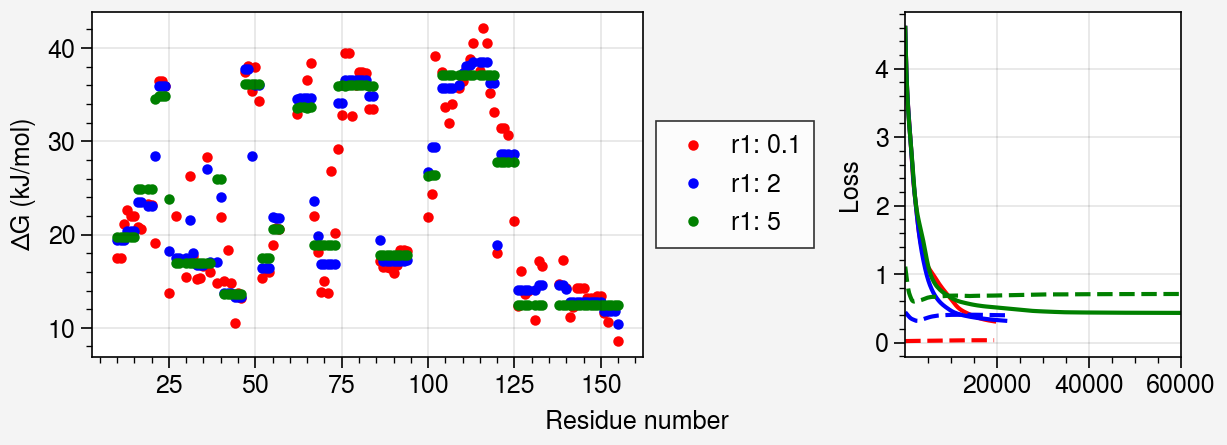

In [54]:
colors = iter(["r", "b", "g"])
fig, axes = uplt.subplots(ncols=2, refaspect=1.6, axwidth="70mm", sharey=False, wratios=[2, 1])
for k, v in results_dict.items():
    print(v.regularization_percentage)
    color = next(colors)
    axes[0].scatter(
        v.output.index, v.output["SecB WT apo"]["dG"] * 1e-3, color=color, label=f"r1: {k}", s=10
    )
    axes[0].set_xlabel("Residue number")
    axes[0].set_ylabel("ΔG (kJ/mol)")
    axes[1].plot(v.losses["mse_loss"], color=color)
    axes[1].plot(v.losses["reg_1"], color=color, linestyle="--")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Loss")

axes[0].legend(loc="r", ncols=1)

#### Fit result covariances

Covariances on ΔG are estimated from the Hessian matrix $\mathcal{H}$. This matrix describes the local curvature of $\chi^2$
(sum of squared residuals) at each residue for the set of ΔG values obtained from the fit.
From the Hessian matrix, covariances are determined by taking the diagonal elements of the square root of the inverse of
the negative Hessian ($\sqrt{\left|(-\mathcal{H})^{-1}_{ii}\right|}$).

When these covariances are high, the optimization landscape is flat and therefore it presents a higher difficulty to finding
the exact minimum. High covariances frequently signal that the obtained ΔG values are at the extreme ends of the time
resolution of the experiment. In these regions, the ΔG values found represent an upper or lower limit and in order to
improve the ΔG range of the experiment shorter or longer timepoints need to be added.

Covariances are stored in the fit result and we can plot these on top of the ΔG values to see which regions are within the
range of the experiment.

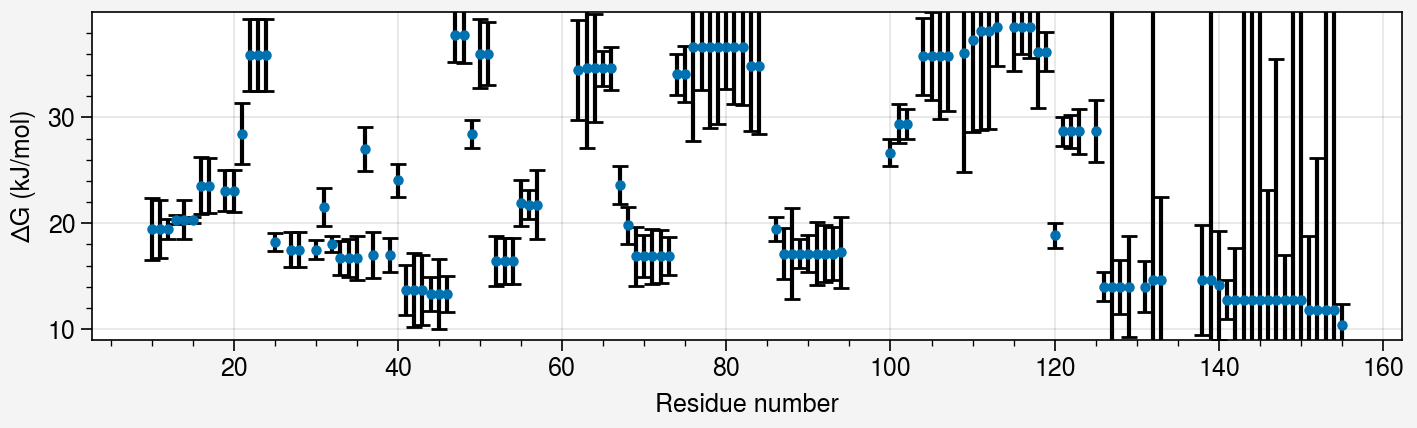

In [55]:
colors = iter(["r", "b", "g"])
fig, ax = uplt.subplots(ncols=1, width="180mm", aspect=4)
v = results_dict[2]

ax.scatter(v.output.index, v.output["SecB WT apo"]["dG"] * 1e-3, s=10)
ylim = ax.get_ylim()
ax.errorbar(
    v.output.index,
    v.output["SecB WT apo"]["dG"] * 1e-3,
    yerr=v.output["SecB WT apo"]["covariance"] * 1e-3,
    linestyle="none",
    color="k",
    zorder=-1,
)
ax.set_ylim(*ylim)
xlabel = ax.set_xlabel("Residue number")
ylabel = ax.set_ylabel("ΔG (kJ/mol)")

In the graph above, covariances are high at SecB's disordered c-tail, highlighting that ΔG values obtained here represent
an upper limit where the actual ΔG values are likely to be lower. Likewise, high ΔG values also show high covariances which
can be improved by adding longer D-exposure datapoints.
Shorter D-exposure datapoints can be added in principle, but regions with low ΔG are more likely to exchagne via EX1 kinetics,
where PyHDX kinetics approximations break down.

Finally, the obtained ΔG values can be plotted with PyHDX default setings and colors using `dG_scatter_figure`. More plotting options are shown in the next chapter.

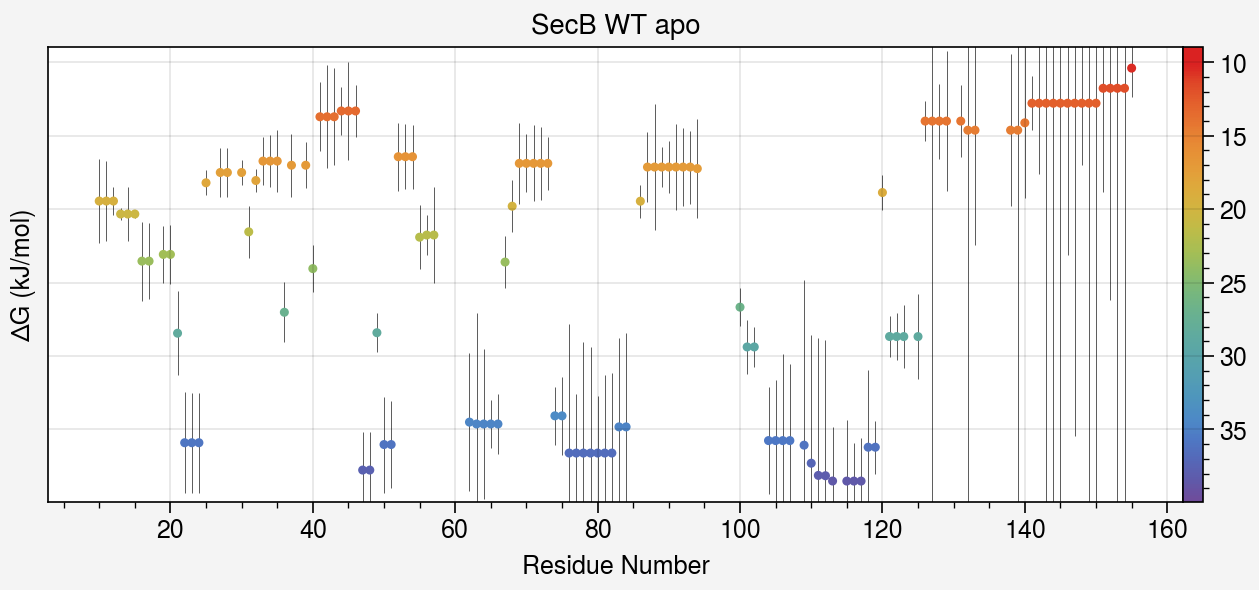

In [56]:
from pyhdx.plot import dG_scatter_figure
v = results_dict[2]
_ = dG_scatter_figure(v.output)